# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/assignment3_part1/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/assignment3_part1/" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

/content/drive/MyDrive/assignment3_part1


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__getitem__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1:
        img_rot = transforms.functional.rotate(img, 90)
        return img_rot
    elif rot == 2:
        img_rot = transforms.functional.rotate(img, 180)
        return img_rot
    elif rot == 3:
        img_rot = transforms.functional.rotate(img, 270)
        return img_rot
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


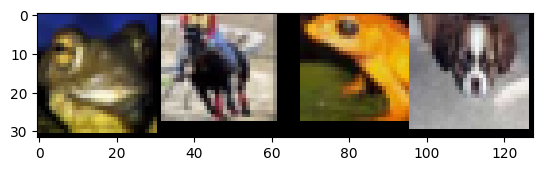

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  frog  horse frog  dog  


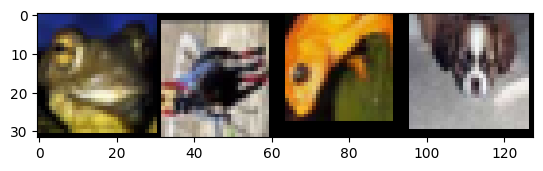

Rotation labels:  0     90    90    0    


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [4]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
                images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
                images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct = correct + (predicted == labels).sum().item()
            total = total + labels.size(0)
            # loss
            avg_test_loss += criterion(outputs, labels) / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [8]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [9]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                inputs = imgs_rotated.to(device)
                labels = rotation_label.to(device)
            elif task == 'classification':
                inputs = imgs.to(device)
                labels = cls_label.to(device)
            else:
                raise ValueError('invalid task name')

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            _, predicted = torch.max(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [10]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
PATH = './model.pth'
torch.save(net.state_dict(), PATH)


[1,   100] loss: 1.358 acc: 39.19 time: 22.77
[1,   200] loss: 1.178 acc: 47.58 time: 12.96
[1,   300] loss: 1.160 acc: 49.27 time: 12.97
TESTING:
Accuracy of the network on the 10000 test images: 51.11 %
Average loss on the 10000 test images: 1.151
[2,   100] loss: 1.107 acc: 51.95 time: 13.09
[2,   200] loss: 1.082 acc: 53.75 time: 12.99
[2,   300] loss: 1.065 acc: 55.02 time: 12.94
TESTING:
Accuracy of the network on the 10000 test images: 57.73 %
Average loss on the 10000 test images: 1.009
[3,   100] loss: 1.030 acc: 56.60 time: 13.13
[3,   200] loss: 1.012 acc: 57.20 time: 12.94
[3,   300] loss: 1.010 acc: 57.36 time: 12.94
TESTING:
Accuracy of the network on the 10000 test images: 59.63 %
Average loss on the 10000 test images: 0.955
[4,   100] loss: 1.007 acc: 57.88 time: 13.08
[4,   200] loss: 0.984 acc: 58.47 time: 12.91
[4,   300] loss: 0.966 acc: 59.70 time: 12.93
TESTING:
Accuracy of the network on the 10000 test images: 60.52 %
Average loss on the 10000 test images: 0.954


# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(weights=True).to(device)
# print(net)
print([n for n, _ in net.named_children()])


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/liangwiki04/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [12]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for param in net.parameters():
    param.requires_grad = False

for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True


In [13]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [14]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 2.191 acc: 36.92 time: 11.63
[1,   200] loss: 1.403 acc: 51.34 time: 11.42
[1,   300] loss: 1.291 acc: 54.84 time: 11.42
TESTING:
Accuracy of the network on the 10000 test images: 58.26 %
Average loss on the 10000 test images: 1.314
[2,   100] loss: 1.168 acc: 58.95 time: 11.58
[2,   200] loss: 1.128 acc: 60.70 time: 11.41
[2,   300] loss: 1.121 acc: 61.08 time: 11.37
TESTING:
Accuracy of the network on the 10000 test images: 62.41 %
Average loss on the 10000 test images: 1.379
[3,   100] loss: 1.057 acc: 62.87 time: 11.69
[3,   200] loss: 1.061 acc: 62.35 time: 11.45
[3,   300] loss: 1.041 acc: 63.70 time: 11.46
TESTING:
Accuracy of the network on the 10000 test images: 61.86 %
Average loss on the 10000 test images: 1.373
[4,   100] loss: 0.997 acc: 64.89 time: 11.63
[4,   200] loss: 1.002 acc: 65.48 time: 11.51
[4,   300] loss: 0.995 acc: 65.23 time: 11.45
TESTING:
Accuracy of the network on the 10000 test images: 64.34 %
Average loss on the 10000 test images: 1.272


# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18().to(device)
# print(net)
print([n for n, _ in net.named_children()])


['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


In [17]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for param in net.parameters():
    param.requires_grad = False

for param in net.layer4.parameters():
    param.requires_grad = True

for param in net.fc.parameters():
    param.requires_grad = True


In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.356 acc: 23.04 time: 11.58
[1,   200] loss: 1.990 acc: 28.62 time: 11.36
[1,   300] loss: 1.950 acc: 29.88 time: 11.37
TESTING:
Accuracy of the network on the 10000 test images: 33.57 %
Average loss on the 10000 test images: 1.908
[2,   100] loss: 1.891 acc: 32.14 time: 11.67
[2,   200] loss: 1.864 acc: 32.96 time: 11.36
[2,   300] loss: 1.838 acc: 33.54 time: 11.38
TESTING:
Accuracy of the network on the 10000 test images: 37.61 %
Average loss on the 10000 test images: 1.726
[3,   100] loss: 1.842 acc: 33.37 time: 11.58
[3,   200] loss: 1.813 acc: 35.20 time: 11.41
[3,   300] loss: 1.804 acc: 34.30 time: 11.34
TESTING:
Accuracy of the network on the 10000 test images: 38.84 %
Average loss on the 10000 test images: 1.734
[4,   100] loss: 1.789 acc: 35.38 time: 11.54
[4,   200] loss: 1.768 acc: 36.01 time: 11.34
[4,   300] loss: 1.762 acc: 36.30 time: 11.41
TESTING:
Accuracy of the network on the 10000 test images: 39.66 %
Average loss on the 10000 test images: 1.679


# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(weights=True).to(device)
for param in net.parameters():
    param.requires_grad = True


In [22]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [23]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.302 acc: 26.05 time: 13.26
[1,   200] loss: 1.521 acc: 45.63 time: 13.06
[1,   300] loss: 1.185 acc: 59.16 time: 13.04
TESTING:
Accuracy of the network on the 10000 test images: 68.38 %
Average loss on the 10000 test images: 0.915
[2,   100] loss: 0.924 acc: 68.23 time: 13.26
[2,   200] loss: 0.882 acc: 70.16 time: 13.13
[2,   300] loss: 0.827 acc: 72.02 time: 13.13
TESTING:
Accuracy of the network on the 10000 test images: 72.96 %
Average loss on the 10000 test images: 0.823
[3,   100] loss: 0.749 acc: 74.80 time: 13.38
[3,   200] loss: 0.721 acc: 75.64 time: 13.16
[3,   300] loss: 0.685 acc: 76.59 time: 13.15
TESTING:
Accuracy of the network on the 10000 test images: 76.86 %
Average loss on the 10000 test images: 0.689
[4,   100] loss: 0.637 acc: 78.11 time: 13.37
[4,   200] loss: 0.627 acc: 78.26 time: 13.14
[4,   300] loss: 0.630 acc: 78.79 time: 13.12
TESTING:
Accuracy of the network on the 10000 test images: 78.61 %
Average loss on the 10000 test images: 0.626


# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18().to(device)
for param in net.parameters():
    param.requires_grad = True


In [25]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [26]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.195 acc: 27.48 time: 13.28
[1,   200] loss: 1.699 acc: 38.18 time: 13.05
[1,   300] loss: 1.581 acc: 41.94 time: 13.05
TESTING:
Accuracy of the network on the 10000 test images: 49.58 %
Average loss on the 10000 test images: 1.355
[2,   100] loss: 1.426 acc: 48.40 time: 13.30
[2,   200] loss: 1.365 acc: 50.84 time: 13.12
[2,   300] loss: 1.323 acc: 51.94 time: 13.13
TESTING:
Accuracy of the network on the 10000 test images: 54.44 %
Average loss on the 10000 test images: 1.267
[3,   100] loss: 1.227 acc: 55.64 time: 13.27
[3,   200] loss: 1.194 acc: 57.54 time: 13.09
[3,   300] loss: 1.158 acc: 58.85 time: 13.11
TESTING:
Accuracy of the network on the 10000 test images: 63.36 %
Average loss on the 10000 test images: 1.039
[4,   100] loss: 1.059 acc: 62.05 time: 13.29
[4,   200] loss: 1.081 acc: 61.37 time: 13.11
[4,   300] loss: 1.057 acc: 62.58 time: 13.11
TESTING:
Accuracy of the network on the 10000 test images: 63.96 %
Average loss on the 10000 test images: 1.003
